
[INFO] Memproses education_index and healthcare_index tahun_2000.png...
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun_2001.png...
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun_2002.png...
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun_2003.png...
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun_2004.png...
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun_2005.png...
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun_2006.png...
  -> Mengekstrak 'education

C:\Users\VICTUS\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


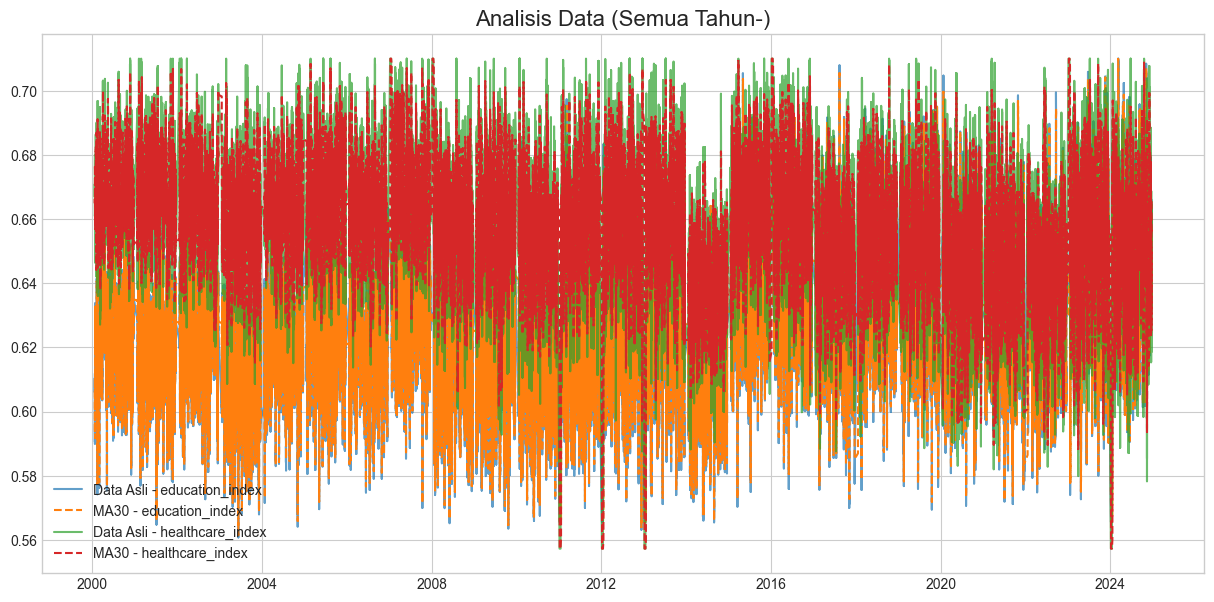


✅ SUKSES! 800401 baris data disimpan ke education_healthcare_extracted.csv


In [8]:
import cv2
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import pytesseract
from typing import List, Dict, Tuple, Optional, Any
from datetime import datetime, timedelta

# (Letakkan salah satu blok CONFIG dari atas di sini, sesuai data Anda)
# Contoh untuk education_index and healthcare_index
CONFIG = {
    "folder_path": r"C:\Users\VICTUS\Downloads\Big-data\Data\C10\education_index and healthcare_index",
    # ... other configurations}",
    "output_csv_file": "education_healthcare_extracted.csv",
    "years_to_process": [],
    "fallback_y_min": 0.55,
    "fallback_y_max": 0.72,
    "clamp_y_min": 0.54,
    "clamp_y_max": 0.71,
    "variables": [
        { "name": "education_index", "lower_color": np.array([90, 80, 50]), "upper_color": np.array([130, 255, 255]) },
        { "name": "healthcare_index", "lower_color": np.array([10, 80, 80]), "upper_color": np.array([25, 255, 255]) }
    ],
    "debug_mode": False
}

# Aktifkan path Tesseract jika disetel di CONFIG
tesseract_cmd = CONFIG.get("tesseract_cmd")
if tesseract_cmd and os.path.exists(tesseract_cmd):
    pytesseract.pytesseract.tesseract_cmd = tesseract_cmd

# ... (Fungsi-fungsi bantu seperti is_leap, clean_mask, dll tidak berubah) ...
def is_leap(year: int) -> bool: return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
def clean_mask(mask: np.ndarray) -> np.ndarray:
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
def preprocess_for_ocr(image: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    return cv2.resize(thresh, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
def extract_year_from_title(title_crop: np.ndarray) -> Optional[int]:
    try:
        title_text = pytesseract.image_to_string(title_crop, config="--psm 6")
        match = re.search(r'\b(20\d{2})\b', title_text)
        if match: return int(match.group(1))
    except Exception: pass
    return None
def extract_series_from_mask(mask: np.ndarray, params: Dict[str, Any]) -> pd.DataFrame:
    extracted_data = []
    plot_h, plot_w = mask.shape
    days_in_year = 366 if is_leap(params['year']) else 365
    start_date = datetime(params['year'], 1, 1)
    for x_pixel in range(plot_w):
        y_pixels = np.where(mask[:, x_pixel] > 0)[0]
        if len(y_pixels) > 0:
            y_pixel_center = int(np.median(y_pixels))
            value = params['y_max'] - ((y_pixel_center / plot_h) * (params['y_max'] - params['y_min']))
            value = max(min(value, params['clamp_y_max']), params['clamp_y_min'])
            day_of_year = int((x_pixel / plot_w) * days_in_year)
            date = start_date + timedelta(days=day_of_year)
            extracted_data.append({
                "Date": date.strftime("%Y-%m-%d"), "Year": params['year'], 
                "DayOfYear": day_of_year + 1, params['var_name']: round(value, 4)
            })
    return pd.DataFrame(extracted_data)


def process_single_image(image_path: str, config: Dict[str, Any]) -> Optional[pd.DataFrame]:
    """Memproses satu file gambar dan mengembalikan hasilnya sebagai DataFrame."""
    print(f"\n[INFO] Memproses {os.path.basename(image_path)}...")
    img = cv2.imread(image_path)
    if img is None: return None

    h, w, _ = img.shape
    title_crop = img[0:int(h*0.1), 0:w]
    plot_area = img[int(h*0.12):int(h*0.9), int(w*0.05):int(w*0.98)]
    
    year_ocr = extract_year_from_title(title_crop)
    year_from_file = int(re.search(r'(\d{4})', image_path).group(1))
    year = year_ocr if year_ocr else year_from_file
    y_min, y_max = config['fallback_y_min'], config['fallback_y_max']

    hsv = cv2.cvtColor(plot_area, cv2.COLOR_BGR2HSV)
    
    # ✨ BARU: Logika fleksibel untuk menangani satu atau banyak variabel
    if 'variables' in config:
        variables_to_process = config['variables']
    else:
        variables_to_process = [{
            "name": config['var_name'],
            "lower_color": config['lower_color'],
            "upper_color": config['upper_color']
        }]

    all_vars_df = []
    for var_info in variables_to_process:
        var_name = var_info['name']
        print(f"  -> Mengekstrak '{var_name}'...")
        mask = cv2.inRange(hsv, var_info['lower_color'], var_info['upper_color'])
        cleaned_mask = clean_mask(mask)
        series_params = {
            'year': year, 'y_min': y_min, 'y_max': y_max,
            'clamp_y_min': config['clamp_y_min'], 'clamp_y_max': config['clamp_y_max'],
            'var_name': var_name
        }
        df_var = extract_series_from_mask(cleaned_mask, series_params)
        if not df_var.empty:
            all_vars_df.append(df_var)

    if not all_vars_df: return None
    
    final_df = all_vars_df[0]
    for i in range(1, len(all_vars_df)):
        final_df = pd.merge(final_df, all_vars_df[i], on=["Date", "Year", "DayOfYear"], how="outer")
        
    return final_df.sort_values(by="Date")

def post_process_data(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    """Membersihkan, mengubah, dan menambah fitur pada data gabungan."""
    print("\n[ANALISIS] Memulai pasca-pemrosesan data...")
    proc_df = df.copy()
    proc_df['Date'] = pd.to_datetime(proc_df['Date'])
    proc_df = proc_df.sort_values(by='Date').set_index('Date')
    proc_df.interpolate(method='time', inplace=True)
    proc_df.dropna(inplace=True)
    
    # ✨ BARU: Logika fleksibel untuk menangani satu atau banyak variabel
    if 'variables' in config:
        vars_to_analyze = [v['name'] for v in config['variables']]
    else:
        vars_to_analyze = [config['var_name']]

    for var_name in vars_to_analyze:
        if var_name in proc_df.columns:
            proc_df[f'{var_name}_MA30'] = proc_df[var_name].rolling(window=30).mean()
    
    return proc_df

def visualize_results(df: pd.DataFrame, config: Dict[str, Any]):
    """Membuat plot visual dari data akhir."""
    title = f"Analisis Data ({config.get('start_year', 'Semua Tahun')}-{config.get('end_year', '')})"
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # ✨ BARU: Logika fleksibel untuk menangani satu atau banyak variabel
    if 'variables' in config:
        vars_to_plot = [v['name'] for v in config['variables']]
    else:
        vars_to_plot = [config['var_name']]

    for var_name in vars_to_plot:
        if var_name in df.columns:
            ax.plot(df.index, df[var_name], label=f'Data Asli - {var_name}', alpha=0.7)
            ax.plot(df.index, df[f'{var_name}_MA30'], label=f'MA30 - {var_name}', linestyle='--')

    ax.set_title(title, fontsize=16)
    ax.legend()
    plt.show()

def main(config: Dict[str, Any]):
    """Fungsi utama untuk menjalankan seluruh alur kerja."""
    if not os.path.isdir(config['folder_path']):
        print(f"❌ KESALAHAN: Folder tidak ditemukan di '{config['folder_path']}'.")
        return

    # ... (Logika runner tidak banyak berubah) ...
    all_files = sorted([f for f in os.listdir(config['folder_path']) if f.endswith(".png")])
    results_list = [process_single_image(os.path.join(config['folder_path'], f), config) for f in all_files]
    valid_results = [df for df in results_list if df is not None and not df.empty]
    if not valid_results:
        print("\n⚠️ PROSES SELESAI: Tidak ada data yang berhasil diekstrak.")
        return

    raw_df = pd.concat(valid_results, ignore_index=True)
    analyzed_df = post_process_data(raw_df, config)
    visualize_results(analyzed_df, config)
    analyzed_df.reset_index(inplace=True)
    analyzed_df.to_csv(config['output_csv_file'], index=False)
    print(f"\n✅ SUKSES! {len(analyzed_df)} baris data disimpan ke {config['output_csv_file']}")

if __name__ == '__main__':
    main(CONFIG)